# Store Items Demand Forecasting

dataset: https://www.kaggle.com/competitions/demand-forecasting-kernels-only/data

- predict daily item sales for different items and stores
- time series forecasting task 

In [16]:
# imports

# for eda
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# for ML
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split


import warnings

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
sns.set(style="whitegrid")

In [3]:
train = pd.read_csv(r'C:\Users\kvjai\ML PROJECTS\Store items demand forecasting\data\train.csv', parse_dates=['date'])
test = pd.read_csv(r'C:\Users\kvjai\ML PROJECTS\Store items demand forecasting\data\test.csv', parse_dates=['date'])

# EDA

In [6]:
print("Train shape:", train.shape)
print("Test shape:", test.shape)

print("\nPREVIEW:")
display(train.head())

print("\nINFO:")
print(train.info())

print("\nMISSING VALUES:")
print(train.isnull().sum())

Train shape: (913000, 4)
Test shape: (45000, 4)

PREVIEW:


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10



INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB
None

MISSING VALUES:
date     0
store    0
item     0
sales    0
dtype: int64


In [8]:
train.describe()

,date,store,item,sales
count,913000,913000.000000,913000.000000,913000.000000
mean,2015-07-02 11:59:59.999999744,5.500000,25.500000,52.250287
min,2013-01-01 00:00:00,1.000000,1.000000,0.000000
25%,2014-04-02 00:00:00,3.000000,13.000000,30.000000
50%,2015-07-02 12:00:00,5.500000,25.500000,47.000000
75%,2016-10-01 00:00:00,8.000000,38.000000,70.000000
max,2017-12-31 00:00:00,10.000000,50.000000,231.000000
std,NaN,2.872283,14.430878,28.801144


# Global Sales Trend

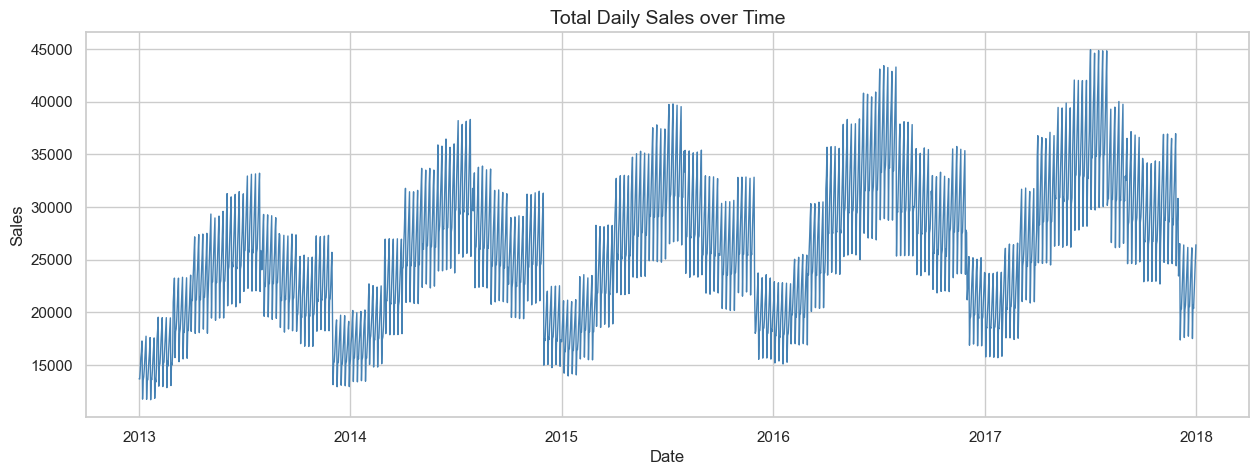

In [9]:
# Aggregate sales per day (all stores or items combined)
daily_sales = train.groupby("date")["sales"].sum().reset_index()

plt.figure(figsize=(15,5))
plt.plot(daily_sales["date"], daily_sales["sales"], color="steelblue", linewidth=1)
plt.title("Total Daily Sales over Time", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

# Monthly sales pattern

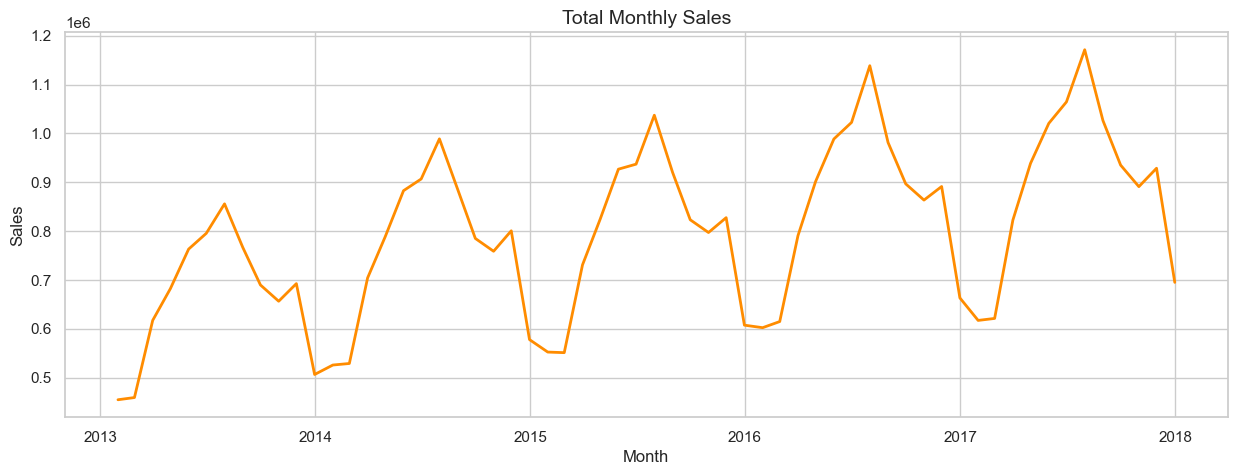

In [10]:
# Resample sales per month (sum across all stores/items)
monthly_sales = train.set_index("date").resample("M")["sales"].sum()

plt.figure(figsize=(15,5))
plt.plot(monthly_sales.index, monthly_sales.values, color="darkorange", linewidth=2)
plt.title("Total Monthly Sales", fontsize=14)
plt.xlabel("Month")
plt.ylabel("Sales")
plt.show()

# Weekly sales pattern

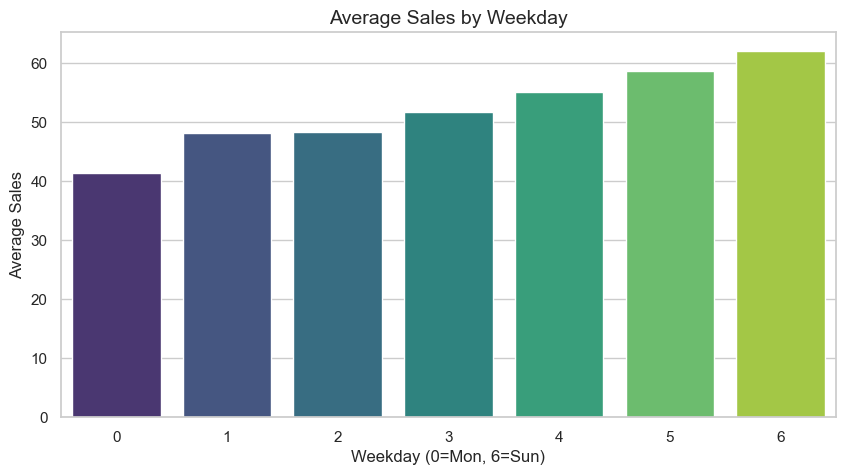

Average sales per weekday:
 weekday
0    41.429638
1    48.225908
2    48.368506
3    51.723218
4    55.157249
5    58.662697
6    62.143333
Name: sales, dtype: float64


In [11]:
# Add weekday column (0 = Monday, 6 = Sunday)
train["weekday"] = train["date"].dt.dayofweek

# Average sales per weekday
weekday_sales = train.groupby("weekday")["sales"].mean()

plt.figure(figsize=(10,5))
sns.barplot(x=weekday_sales.index, y=weekday_sales.values, palette="viridis")
plt.title("Average Sales by Weekday", fontsize=14)
plt.xlabel("Weekday (0=Mon, 6=Sun)")
plt.ylabel("Average Sales")
plt.show()

print("Average sales per weekday:\n", weekday_sales)

# Store level analysis

to understand
- which store sells how much
- if we need the feature store for model
- if there are significant differences between stores

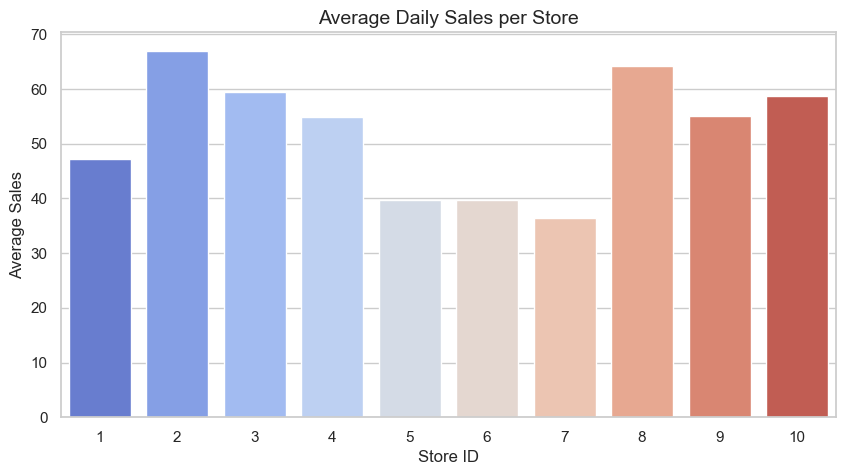

Average daily sales per store:
    store      sales
0      1  47.268379
1      2  67.033165
2      3  59.530602
3      4  54.902946
4      5  39.770164
5      6  39.733516
6      7  36.363735
7      8  64.142048
8      9  55.049025
9     10  58.709288


In [12]:

# Average daily sales per store
store_sales = train.groupby("store")["sales"].mean().reset_index()

plt.figure(figsize=(10,5))
sns.barplot(x="store", y="sales", data=store_sales, palette="coolwarm")
plt.title("Average Daily Sales per Store", fontsize=14)
plt.xlabel("Store ID")
plt.ylabel("Average Sales")
plt.show()

print("Average daily sales per store:\n", store_sales)

# Top 10 items across all stores

most sold items across all

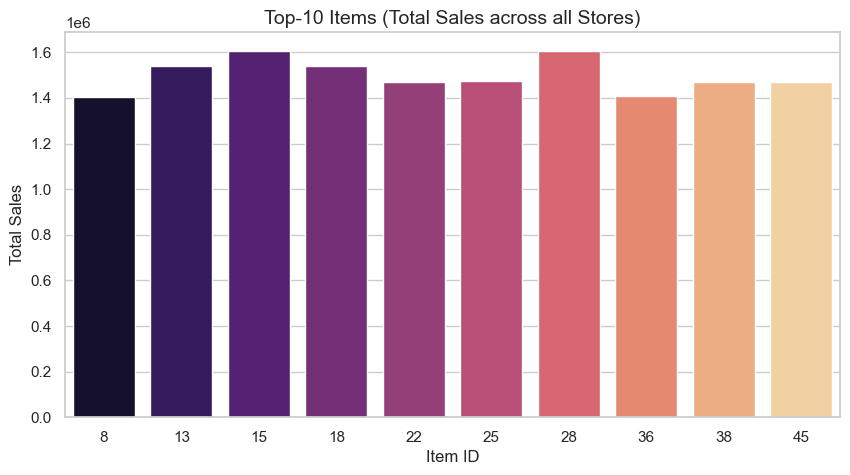

Top-10 items overall:
     item    sales
14    15  1607442
27    28  1604713
12    13  1539621
17    18  1538876
24    25  1473334
44    45  1471467
37    38  1470330
21    22  1469971
35    36  1406548
7      8  1405108


In [13]:
# Total sales per item (all stores combined)
item_sales = train.groupby("item")["sales"].sum().reset_index()

# Top-10 items
top_items = item_sales.sort_values(by="sales", ascending=False).head(10)

plt.figure(figsize=(10,5))
sns.barplot(x="item", y="sales", data=top_items, palette="magma")
plt.title("Top-10 Items (Total Sales across all Stores)", fontsize=14)
plt.xlabel("Item ID")
plt.ylabel("Total Sales")
plt.show()

print("Top-10 items overall:\n", top_items)

# Top seller per store

matrix

In [14]:
# Total sales per store-item combination
store_item_sales = train.groupby(["store", "item"])["sales"].sum().reset_index()

# For each store, find the item with maximum sales
top_item_per_store = store_item_sales.loc[store_item_sales.groupby("store")["sales"].idxmax()]

print("Top-Selling Item per Store:")
display(top_item_per_store)

Top-Selling Item per Store:


,store,item,sales
14,1,15,145497
77,2,28,205677
114,3,15,183373
164,4,15,169186
214,5,15,122319
264,6,15,121737
314,7,15,111640
364,8,15,197295
414,9,15,170069
464,10,15,180757


# Heatmap

Store x Item sales
- rows are storese
- cols are items
- values are total sales 

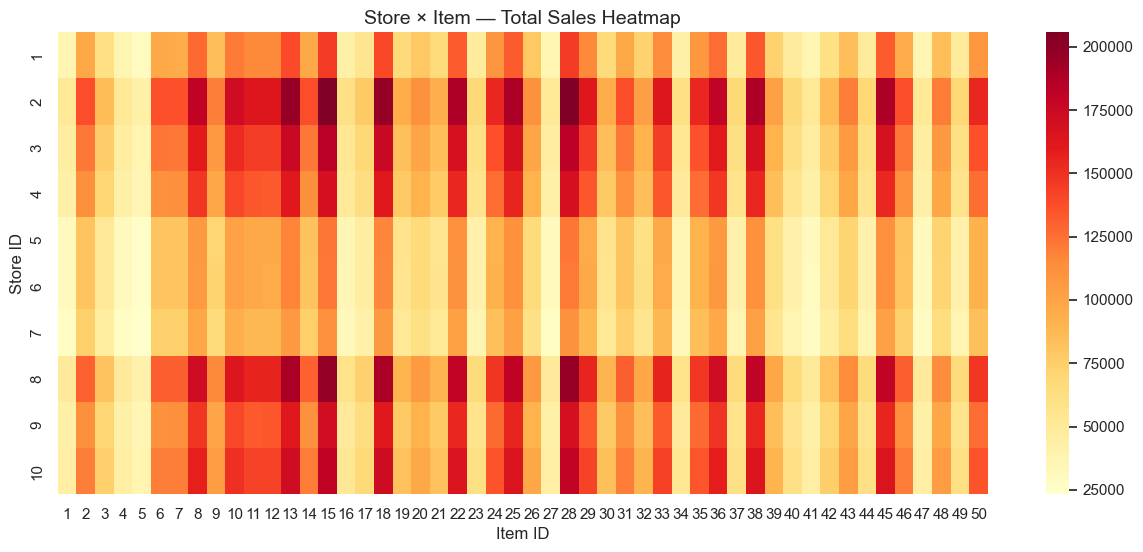

In [15]:
# Pivot table: stores (rows), items (columns), total sales as values
pivot_sales = train.pivot_table(index="store", columns="item", values="sales", aggfunc="sum")

plt.figure(figsize=(15,6))
sns.heatmap(pivot_sales, cmap="YlOrRd", cbar=True)
plt.title("Store × Item — Total Sales Heatmap", fontsize=14)
plt.xlabel("Item ID")
plt.ylabel("Store ID")
plt.show()